# DDPG ball position controller
In this section, the ball controller will be created.

## External imports

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

## Internal imports

In [2]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [3]:
train = False

## PID benchmark
In this section, a traditional PID controller will be designed as a benchmark.

### Target trajectory

In [4]:
def step(duration: float, amplitude: tuple)-> np.ndarray:
    iterations = int((duration // DT))
    ts = np.ones((2, iterations))
    ts[0, :] = amplitude[0] * ts[0, :]
    ts[1, :] = amplitude[1] * ts[1, :]
    return ts

In [5]:
def circle(duration: float, raduis: float)-> np.ndarray:
    pause = int(5. / DT)
    iterations = int(duration // DT)
    ts = np.zeros((2, iterations + pause))
    t = 2. * np.pi / duration * np.linspace(0., duration, num=iterations)
    ts[1, pause:] = raduis * np.cos(t)
    ts[0, pause:] = raduis * np.sin(t)
    ts[1, :pause] = raduis * np.ones(pause)
    return ts

In [6]:
trajectory = np.zeros((2, 100))

for _ in range(2):
    pos = 2. * np.random.rand(2) - 1.
    trajectory = np.hstack((trajectory, step(10., ((0.8 * MAX_X) * pos[0], (0.8 * MAX_Y) * pos[1]))))

for _ in range(1):
    t = 40. * (0.5 + (np.random.rand() / 2.))
    r = (np.random.rand() - 0.5) * (1.6 * MAX_Y)
    trajectory = np.hstack((trajectory, circle(t, r)))

In [7]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

t_test = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

<IPython.core.display.Javascript object>


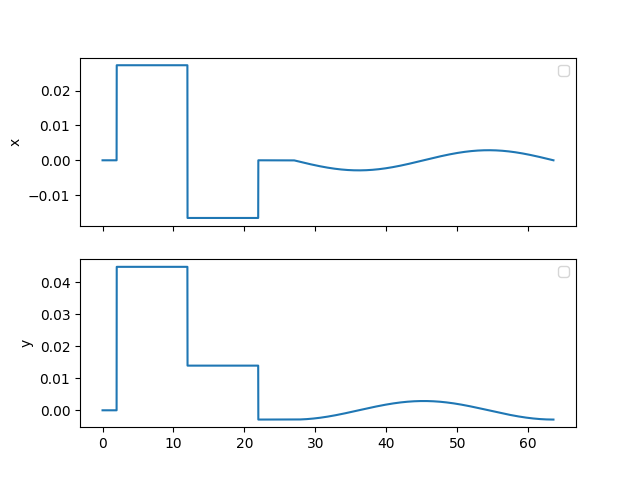

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [8]:
t = np.arange(0., trajectory.shape[1] * DT, DT)


fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(t, trajectory[0, :])
axs[0].set_ylabel('x')
axs[0].legend()

axs[1].plot(t, trajectory[1, :])
axs[1].set_ylabel('y')
axs[1].legend()

plt.show()

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.02150242, -0.05291468], dtype=float32), array([0.03650627, 0.01253975], dtype=float32), array([0.00145798, 0.00284293], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Generation = 1
Fitness    = -6.0375758055570603e-05
Generation = 2
Fitness    = -5.125830016857654e-05
Generation = 3
Fitness    = -5.016151561482529e-05
Generation = 4
Fitness    = -4.57852781126514e-05
Generation = 5
Fitness    = -4.854846378759486e-05
Generation = 6
Fitness    = -4.451127071398251e-05
Generation = 7
Fitness    = -4.379996828427768e-05
Generation = 8
Fitness    = -4.1036013840413575e-05
Generation = 9
Fitness    = -5.890446776629071e-05
Generation = 10
Fitness    = -4.008938768866937e-05


<IPython.core.display.Javascript object>


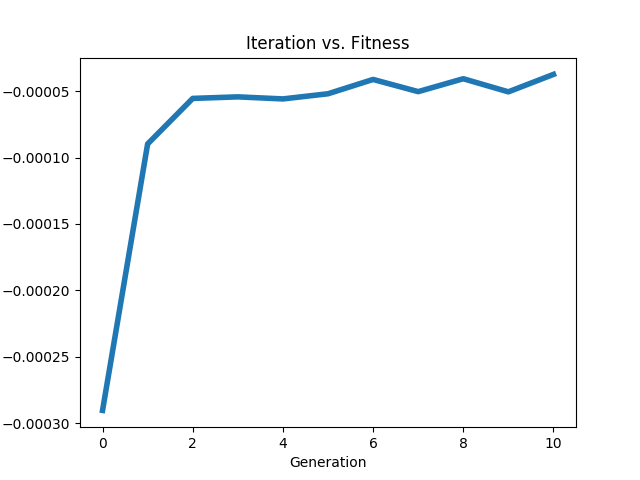

Fitness value of the best solution = -4.002687745202381e-05


/home/benoit/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type PidController. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/benoit/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [9]:
#if train:
pid_controller = train_ball_controller(trajectory, 10, 20)
torch.save(pid_controller, 'src/data/pid_benchmark_nn.pt')

In [10]:
w = pid_controller.predict.weight[0].detach().numpy().tolist()
print(w)

ball_pid = {
    'weights': w,
}

with open('src/data/ball_pid.json', 'w') as json_file:
    json.dump(ball_pid, json_file)

[1.7622685432434082, 0.9453514218330383, 0.28934183716773987]


In [11]:
pid_controller = torch.load('src/data/pid_benchmark_nn.pt')

In [12]:
evaluator: BenchmarkEvaluator = BenchmarkEvaluator(test_trajectory)
    
history_pid, error_pid, u_pid, angle_pid, loss_pid = evaluator.simulate(pid_controller, test=True)
t_test = np.arange(0., test_trajectory.shape[1] * DT, DT)
print(loss_pid)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.06361596, -0.01608821], dtype=float32), array([0.0139724 , 0.06370114], dtype=float32), array([0.00043869, 0.00113214], dtype=float32))
-0.00011139492425404248


In [13]:
benchmark_trajectory = {
    't': t_test.tolist(),
    'target': test_trajectory.tolist(),
    'trajectory': history_pid.tolist(),
    'u': u_pid.tolist(),
    'angle': angle_pid.tolist()
}

In [14]:
with open('src/data/benchmark_trajectory.json', 'w') as json_file:
    json.dump(benchmark_trajectory, json_file)

<IPython.core.display.Javascript object>


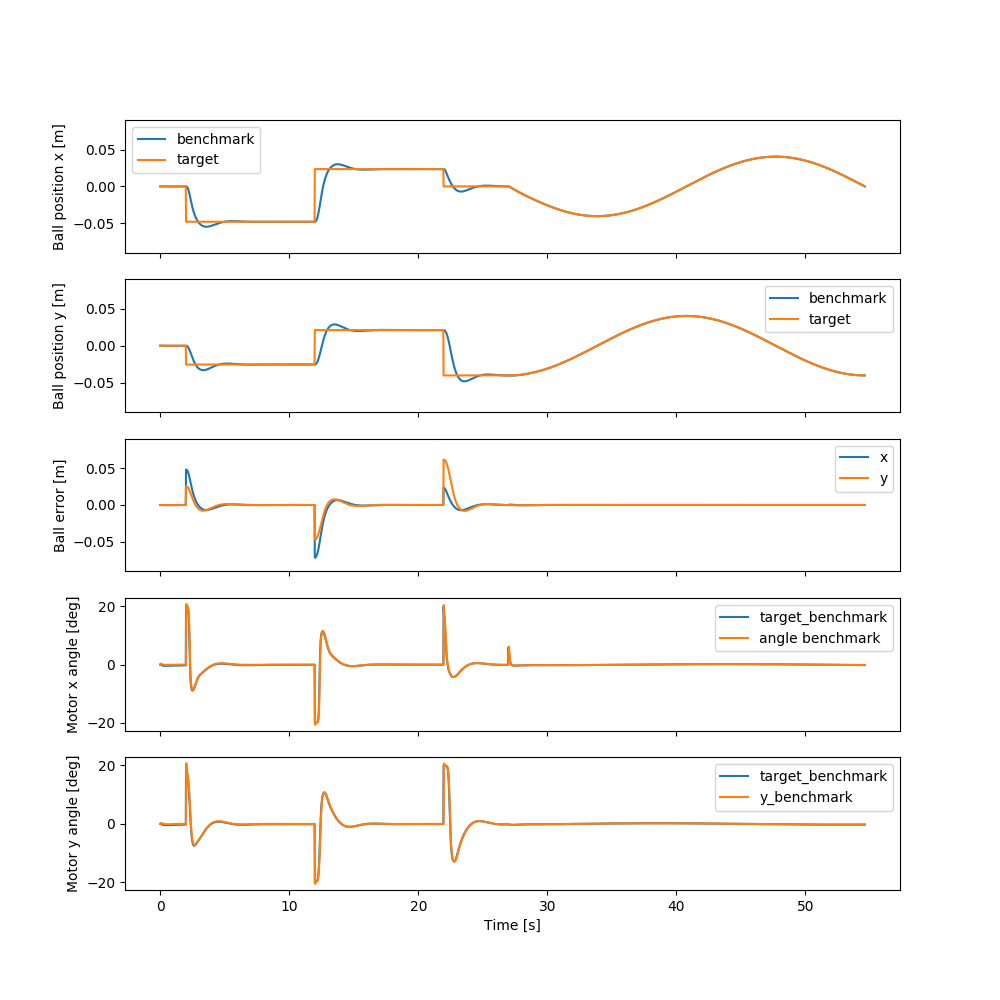

In [15]:
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t_test, history_pid[0, :], label='benchmark')
axs[0].plot(t_test, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t_test, history_pid[1,:], label='benchmark')
axs[1].plot(t_test, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t_test, error_pid[0, :], label='x')
axs[2].plot(t_test, error_pid[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t_test, u_pid[0, :], label='target_benchmark')
axs[3].plot(t_test, angle_pid[0, :], label='angle benchmark')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t_test, u_pid[1, :], label='target_benchmark')
axs[4].plot(t_test, angle_pid[1, :], label='y_benchmark')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

<IPython.core.display.Javascript object>


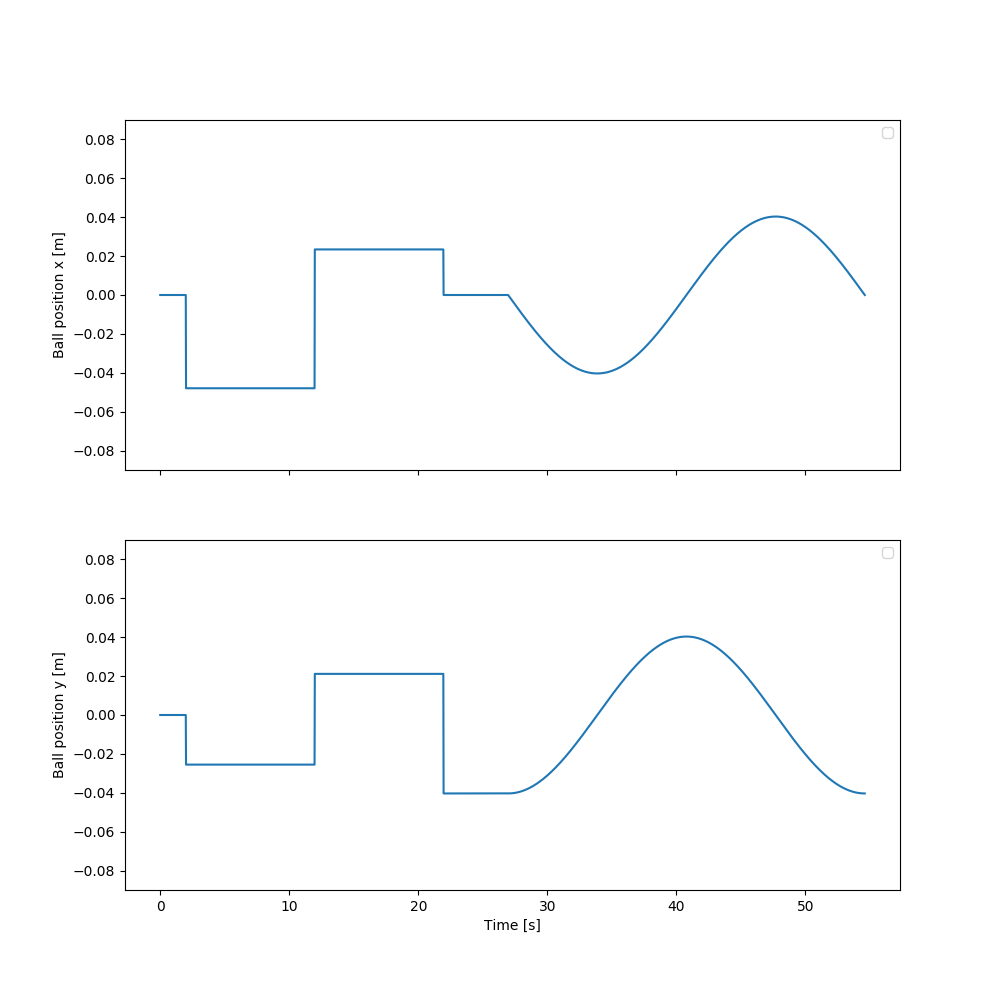

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [16]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, test_trajectory[0, :])
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()
axs[1].plot(t, test_trajectory[1, :])
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()


plt.show()

## DDPG

In this section two DDPG agents will be trained :

- black box controller
- dynamic pid controller

In [13]:
def train_ddpg(env_type, loss, hidden_sizes, activations, epoch, weights):
    if env_type == 'black_box_controller':
        env = BBEnv
        ac = MLPActorCritic
    else:
        env = BBEnvPid
        ac = PidActorCritic
        
    if loss == 'e_r':
        r_fc = linear_e_reward
    elif loss == 'de_r':
        r_fc = linear_de_reward
        
    
    for activation in activations:
        for hidden_size in hidden_sizes:
            for w in weights:
                if activation == 'relu':
                    act = torch.nn.ReLU
                elif activation == 'sigmoid':
                    act = torch.nn.Sigmoid
        
                spinup.ddpg_pytorch(env_fn_gen(env, r_fc, w),
                            actor_critic = ac,    
                            ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                            seed = 0, 
                            steps_per_epoch = 1100, 
                            epochs = epoch, 
                            replay_size = 15000, 
                            gamma = 0.99, 
                            polyak = 0.995, 
                            pi_lr = 0.001,
                            q_lr = 0.001,
                            batch_size = 500, 
                            start_steps = 15000,
                            act_noise = 0.1,
                            max_ep_len = 150,
                            update_every= 100,
                            num_test_episodes=20,
                            logger_kwargs = dict(output_dir='src/data/{}/{}/{}_{}_{}'.format(env_type, loss, w, hidden_size, activation), exp_name='test'),
                            )

In [14]:
env = 'black_box_controller'

loss = 'e_r'

hidden_sizes = [[48, 24]]

l_w = [0.3]

activations = ['sigmoid']

epoch = 300

if train:
    train_ddpg(env, loss, hidden_sizes, activations, epoch, l_w)

<IPython.core.display.Javascript object>


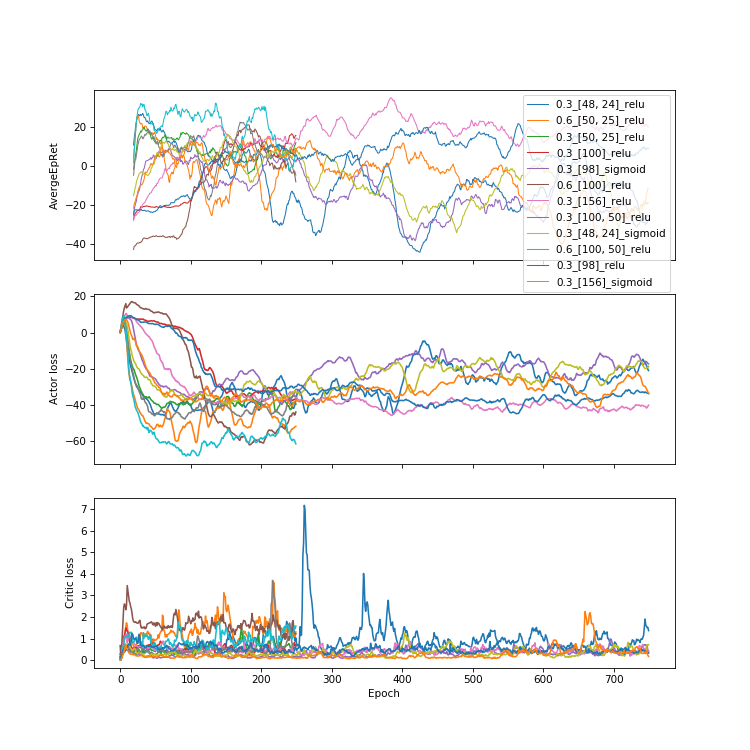

In [15]:
analyse_training(env, loss)

In [32]:
ac = torch.load('src/data/black_box_controller/e_r/0.6_[100, 50]_relu/pyt_save/model.pt')
evaluator_ddpg = BBEnv()

history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(ac, trajectory)

print(loss_ddpg)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.04937305,  0.00257041], dtype=float32), array([-0.02918214,  0.05730472], dtype=float32), array([-0.00094494,  0.00028776], dtype=float32))
-14793597743.935246


In [24]:
env = 'dyn_pid_controller'

loss = 'e_r'

hidden_sizes = [[98, 48], [48, 24]]

l_w = [0.4]

activations = ['relu']#['relu', 'sigmoid']

epoch = 750

if train:
    train_ddpg(env, loss, hidden_sizes, activations, epoch, l_w)

<IPython.core.display.Javascript object>


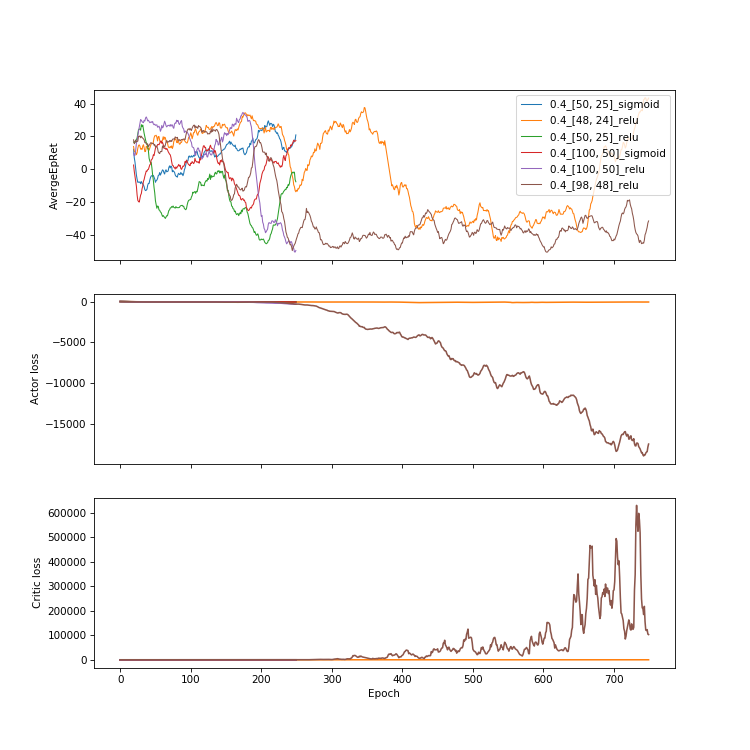

In [25]:
analyse_training(env, loss)

In [26]:
env_pid = BBEnvPid()

ac_pid = torch.load('src/data/dyn_pid_controller/e_r/0.4_[50, 25]_relu/pyt_save/model.pt')

history_ddpg_pid, error_ddpg_pid, u_ddpg_pid, angle_ddpg_pid, loss_ddpg_pid, kp, kd, ki = env_pid.simulate(ac_pid, trajectory)

print(loss_ddpg_pid)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.00265081, 0.05152443], dtype=float32), array([0.03803294, 0.02644603], dtype=float32), array([ 0.00080052, -0.00106973], dtype=float32))
-0.00047554629380558


## Test

In this section, all controllers will be compared.

<IPython.core.display.Javascript object>


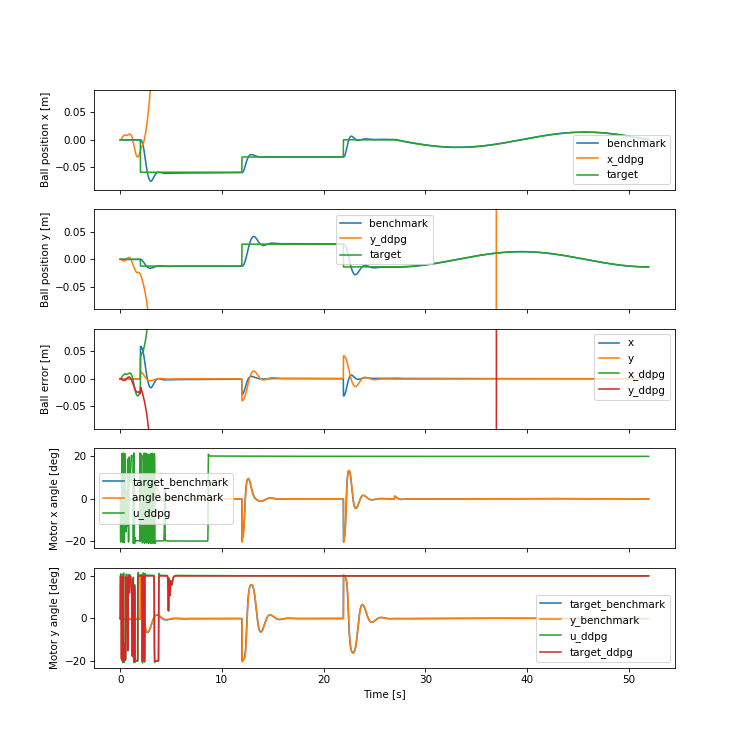

In [33]:
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_pid[0, :], label='benchmark')
axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
#axs[0].plot(t, history_ddpg_pid[0, :], label='x_ddpg_pid')
axs[0].plot(t, trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_pid[1,:], label='benchmark')
axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
#axs[1].plot(t, history_ddpg_pid[1,:], label='y_ddpg_pid')
axs[1].plot(t, trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_pid[0, :], label='x')
axs[2].plot(t, error_pid[1, :], label='y')
axs[2].plot(t, error_ddpg[0, :], label='x_ddpg')
axs[2].plot(t, error_ddpg[1, :], label='y_ddpg')
#axs[2].plot(t, error_ddpg_pid[0, :], label='x_ddpg_pid')
#axs[2].plot(t, error_ddpg_pid[1, :], label='y_ddpg_pid')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, u_pid[0, :], label='target_benchmark')
axs[3].plot(t, angle_pid[0, :], label='angle benchmark')
axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
#axs[3].plot(t[19:], np.convolve(u_ddpg[0, :], np.ones(20), 'valid') / 20., label='target_ddpg')
#axs[3].plot(t, angle_ddpg_pid[0, :], label='u_ddpg_pid')
#axs[3].plot(t, u_ddpg_pid[0, :], label='target_ddpg_pid')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, u_pid[1, :], label='target_benchmark')
axs[4].plot(t, angle_pid[1, :], label='y_benchmark')
axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
#axs[4].plot(t, angle_ddpg_pid[1, :], label='u_ddpg_pid')
#axs[4].plot(t, u_ddpg_pid[1, :], label='target_ddpg_pid')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

#axs[5].plot(t, kp[0, :], label='kp')
#axs[5].plot(t, kd[0, :], label='kd')
#axs[5].plot(t, ki[0, :], label='ki')
#axs[5].set_ylabel('PID x weights')
#axs[5].legend()

#axs[6].plot(t, kp[1, :], label='kp')
#axs[6].plot(t, kd[1, :], label='kd')
#axs[6].plot(t, ki[1, :], label='ki')
#axs[6].set_ylabel('PID y weights')
#axs[6].legend()

plt.show()